# Importacion de librerias

## Exploración de datos y visualización

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## Manejo de Rasters

In [3]:
import rasterio as rio
import matplotlib.patches as mpatches
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image
from tqdm import tqdm
from pyproj import Proj, transform
from shapely.geometry import Polygon
from osgeo import gdal, ogr, osr

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Utilidades

### Establecer semilla aleatoria para la reproductibilidad

In [7]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [ ]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

## Diccionario de todas las clases e identificadores de clase

In [ ]:
class_names = dict((
    (0, 'Sin Clasificar'),
    (1, 'Bosque'),
    (2, 'Cuerpo de Agua'),
    (3, 'Otras Tierras'),
    (4, 'Tierra Agropecuaria'),
    (5, 'Vegetacion Arbustiva y Herbacea'),
    (6, 'Zona Antropica'),
))

In [ ]:
colors_class = dict((
    (0, (0, 0, 0)),         # Background
    (1, (62, 178, 49)),     # Arboles
    (2, (0, 0, 251)),       # Water
    (3, (122, 125, 74)),    # Otras Tierras (Sin cobertura vegetal)
    (4, (245, 106, 0)),     # Tierra Agropecuaria
    (5, (255, 165, 81)),    # Vegetacion Arbustiva y Herbacea
    (6, (255, 0, 0)),       # Area Construida
))

In [ ]:
reclassification = {
    255: 0      # Change 255 to 0
}

### Fusionar las clases NLCD en un subconjunto más manejable.

In [11]:
def merge_classes(y):
    if reclassification is None:
        return []

    if not isinstance(reclassification, dict):
        raise TypeError("Reclassification must be a dictionary.")

    for index, item in reclassification.items():
        y[y == index] = item

    return y

# Configuracion de directiorios de los mosaicos

In [12]:
label_path = '../data/images/processed/labels/landsat/landcover_ecuador_v1.tif'
rasters_path = '../data/images/processed/products/L8'

# Preprocesamiento de clases NLCD

In [ ]:
import sys
sys.path.append('../')
from src.utils.utilities import *
from src.utils.pixel import *

# Procesamiento de la imagen de etiquetas NLDC

In [15]:
dataset_labels = open_raster(label_path)

Numero de bandas en la imagen: 1

Tamaño de la imagen es: 25540 filas x 34000 columnas

Raster driver: GTiff

Proyeccion de Imagen:
EPSG:32717


## Lectura de mosaico

In [16]:
labels_image = read_raster(dataset_labels)
labels_image.shape

(1, 25540, 34000)

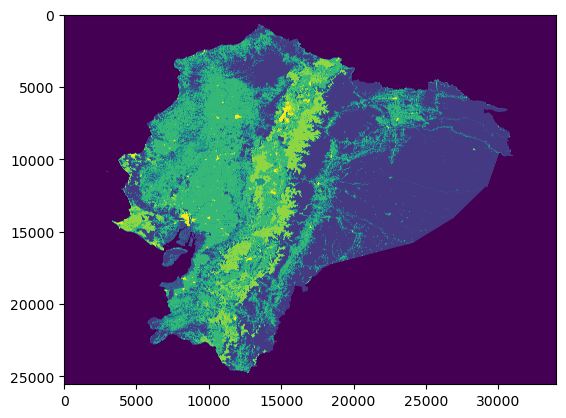

<Axes: >

In [17]:
show(labels_image)

### Total de clases originales NLDC

In [ ]:
data_list = samples_by_class(labels_image, class_names)
data_list

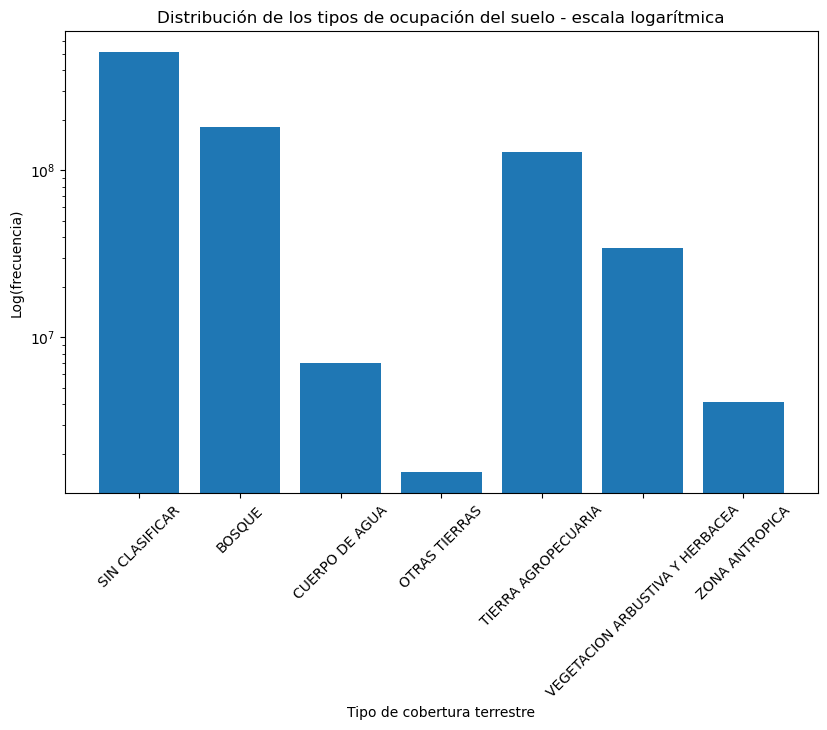

In [19]:
fig = plt.figure(figsize=(1.62*6, 6)) 
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Tipo de cobertura terrestre")
plt.ylabel("Log(frecuencia)")
plt.title("Distribución de los tipos de ocupación del suelo - escala logarítmica")
_ = plt.bar([classe[0] for classe in data_list], [classe[1] for classe in data_list])

### Proporcion de muestras por clases originales

In [20]:
unique, counts = np.unique(labels_image, return_counts=True)
unique, counts = unique[1:], counts[1:]  # skip 0
prop_list = []
for ii, jj in enumerate(unique):
    prop_list.append(counts[ii]/np.sum(counts))
    print(str(class_names[jj]+': '), '{:.2f}'.format(counts[ii]/np.sum(counts)))

BOSQUE:  0.51
CUERPO DE AGUA:  0.02
OTRAS TIERRAS:  0.00
TIERRA AGROPECUARIA:  0.36
VEGETACION ARBUSTIVA Y HERBACEA:  0.10
ZONA ANTROPICA:  0.01


## Mezclar clases cobertura terrestre

In [21]:
images_merge = merge_classes(labels_image)
images_merge.shape

(1, 25540, 34000)

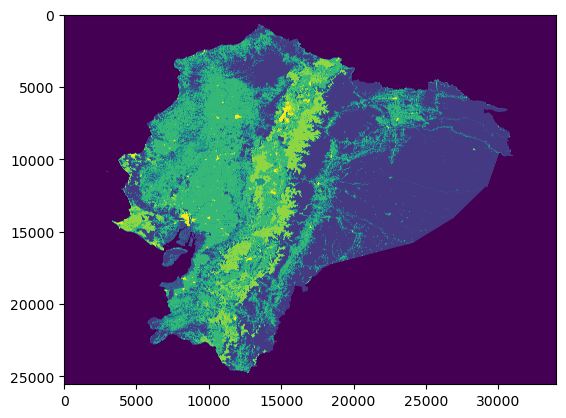

<Axes: >

In [22]:
show(images_merge)

### Total de clases mezcladas NLDC

In [23]:
unique, counts = np.unique(images_merge, return_counts=True)
data_listm = [(class_names[x], counts) for x, counts in list(zip(unique, counts))]
data_listm

[('SIN CLASIFICAR', 511054838),
 ('BOSQUE', 181339750),
 ('CUERPO DE AGUA', 7058888),
 ('OTRAS TIERRAS', 1558991),
 ('TIERRA AGROPECUARIA', 129146919),
 ('VEGETACION ARBUSTIVA Y HERBACEA', 34098007),
 ('ZONA ANTROPICA', 4102607)]

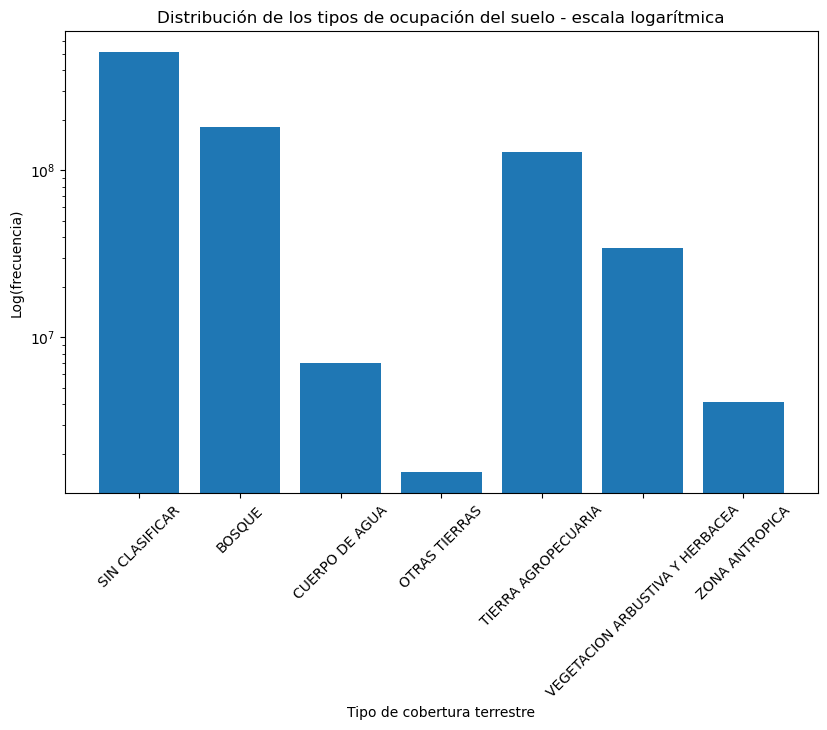

In [24]:
fig = plt.figure(figsize=(1.62*6, 6))
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Tipo de cobertura terrestre")
plt.ylabel("Log(frecuencia)")
plt.title("Distribución de los tipos de ocupación del suelo - escala logarítmica")
_ = plt.bar([classe[0] for classe in data_listm], [classe[1] for classe in data_listm])

### Proporcion de muestras por clases mezcladas

In [25]:
unique, counts = np.unique(images_merge, return_counts=True)
unique, counts = unique[1:], counts[1:]  # skip 0
prop_list = []
for ii, jj in enumerate(unique):
    prop_list.append(counts[ii]/np.sum(counts))
    print(str(class_names[jj]+': '),'{:.2f}'.format(counts[ii]/np.sum(counts)))

BOSQUE:  0.51
CUERPO DE AGUA:  0.02
OTRAS TIERRAS:  0.00
TIERRA AGROPECUARIA:  0.36
VEGETACION ARBUSTIVA Y HERBACEA:  0.10
ZONA ANTROPICA:  0.01


### Visualizar clases mezcladas

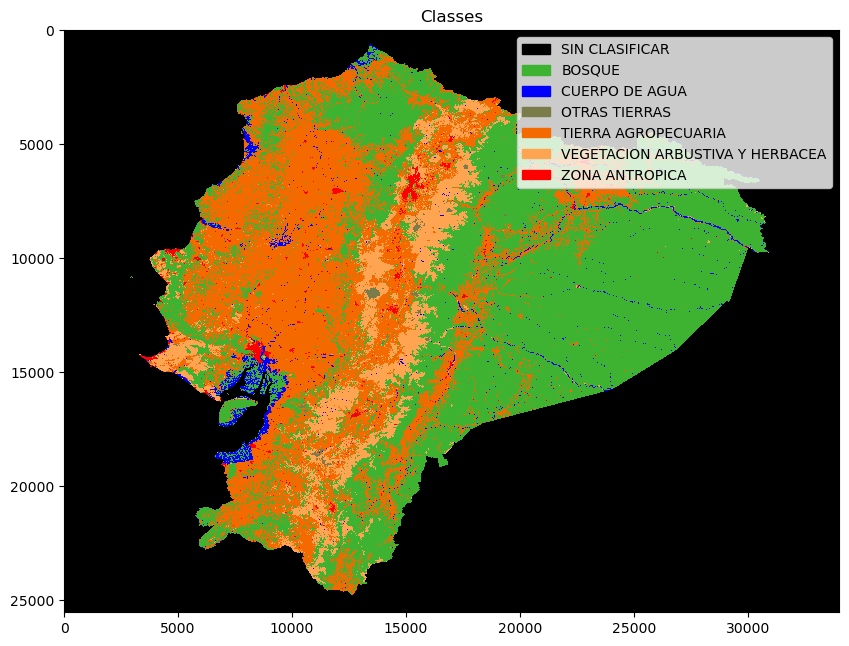

In [26]:
n = int(np.max(images_merge)) + 1

# Put 0 - 255 as float 0 - 1
for k in colors_class:
    v = colors_class[k]
    _v = [_v / 255.0 for _v in v]
    colors_class[k] = _v

index_false_colors = [colors_class[key] for key in range(0, n)]

cmap_false_colors = plt.matplotlib.colors.ListedColormap(
    index_false_colors, 'Classification', n)

patches = [mpatches.Patch(color=cmap_false_colors.colors[class_id], label=class_names[class_id])
           for class_id in range(len(cmap_false_colors.colors))]

fig, axs = plt.subplots(figsize=(10, 10))

# location of training pixels on the image
_ = axs.imshow(labels_image[0, :, :],
               cmap=cmap_false_colors,
               interpolation='none')
axs.legend(handles=patches)
axs.set_title('Classes')

plt.show()

# Preprocesamiento del mosaico de estudio  

In [27]:
path_rasters = 'D:\\Programación\\LandCover\\geo\\data\\rasters\\landsat-8'
rasters =  [rio.open(f'{path_rasters}\\{raster}') for raster in os.listdir(path_rasters)]

# Generar datos de entrenamiento balanceados

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
train_pixels = gen_balanced_pixel_locations(
    rasters,
    train_count=15000,
    label_dataset=dataset_labels,
    merge=True
)

train_count_per_dataset: 715
points_per_class: 102
raster_points: ((564585.0, -363885.0), (792615.0, -363885.0), (792615.0, -596415.0), (564585.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:57<00:00, 25.31s/it]                 


points_per_class: 102
raster_points: ((561585.0, -363885.0), (789915.0, -363885.0), (789915.0, -596415.0), (561585.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:55<00:00, 25.09s/it]                 


points_per_class: 102
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:56<00:00, 25.18s/it]                 


points_per_class: 102
raster_points: ((562785.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562785.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:54<00:00, 24.96s/it]                 


points_per_class: 102
raster_points: ((562485.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562485.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.80s/it]                 


points_per_class: 102
raster_points: ((562185.0, -363885.0), (790515.0, -363885.0), (790515.0, -596415.0), (562185.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.84s/it]                 


points_per_class: 102
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:52<00:00, 24.60s/it]                 


points_per_class: 102
raster_points: ((563685.0, -363885.0), (791715.0, -363885.0), (791715.0, -596415.0), (563685.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.52s/it]                 


points_per_class: 102
raster_points: ((563685.0, -363885.0), (792015.0, -363885.0), (792015.0, -596415.0), (563685.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:52<00:00, 24.61s/it]                 


points_per_class: 102
raster_points: ((563985.0, -363885.0), (792315.0, -363885.0), (792315.0, -596415.0), (563985.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:52<00:00, 24.69s/it]                 


points_per_class: 102
raster_points: ((561285.0, -363885.0), (789615.0, -363885.0), (789615.0, -596415.0), (561285.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.77s/it]                 


points_per_class: 102
raster_points: ((564285.0, -363885.0), (792315.0, -363885.0), (792315.0, -596415.0), (564285.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.80s/it]                 


points_per_class: 102
raster_points: ((563085.0, -363885.0), (791415.0, -363885.0), (791415.0, -596415.0), (563085.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.53s/it]                 


points_per_class: 102
raster_points: ((562485.0, -363885.0), (790515.0, -363885.0), (790515.0, -596415.0), (562485.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.82s/it]                 


points_per_class: 102
raster_points: ((565185.0, -363885.0), (793515.0, -363885.0), (793515.0, -596415.0), (565185.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:50<00:00, 24.42s/it]                 


points_per_class: 102
raster_points: ((563685.0, -363885.0), (792015.0, -363885.0), (792015.0, -596415.0), (563685.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.52s/it]                 


points_per_class: 102
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.53s/it]                 


points_per_class: 102
raster_points: ((560085.0, -363885.0), (788415.0, -363885.0), (788415.0, -596415.0), (560085.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.52s/it]                 


points_per_class: 102
raster_points: ((561585.0, -363885.0), (789915.0, -363885.0), (789915.0, -596415.0), (561585.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:52<00:00, 24.63s/it]                 


points_per_class: 102
raster_points: ((562485.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562485.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:51<00:00, 24.52s/it]                 


points_per_class: 102
raster_points: ((559785.0, -363885.0), (788115.0, -363885.0), (788115.0, -596415.0), (559785.0, -596415.0))


Processing « ZONA ANTROPICA »: 100%|██████████| 7/7 [02:53<00:00, 24.73s/it]                 


##  Comprobación de datos
Conjunto de datos equilibrado y correcto. 
Ubicación real de los píxeles.

In [30]:
landsat_datasets = rasters
# generate the training and validation pixel locations
all_labels = []
label_locations = []
progression_bar = tqdm(train_pixels)
for index, pixel in enumerate(progression_bar):
    progression_bar.set_description("Processing data point: %s" % str(index))

    # row, col location in landsat
    r, c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(dataset_labels.crs)

    # localización geográfica
    x, y = landsat_datasets[ds_index].xy(r, c)
    # pasar de la proyección label a la proyección del mosaico
    x, y = transform(l8_proj, label_proj, x, y)
    # obtener la posición de fila y columna en la etiqueta
    r, c = dataset_labels.index(x, y)

    label_locations.append([r, c])

    # formato (bandas, altura, anchura)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(dataset_labels.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0, 0])

label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
points = [(class_names[x], counts) for x, counts in list(zip(unique, counts))]
points

Processing data point: 14993: 100%|██████████| 14994/14994 [1:04:57<00:00,  3.85it/s]


[('SIN CLASIFICAR', 2142),
 ('BOSQUE', 2165),
 ('CUERPO DE AGUA', 2115),
 ('OTRAS TIERRAS', 2099),
 ('TIERRA AGROPECUARIA', 2211),
 ('VEGETACION ARBUSTIVA Y HERBACEA', 2156),
 ('ZONA ANTROPICA', 2106)]

## Visualización de la ubicación de los datos
Muestre ahora el mapa de clases junto a la ubicación de los píxeles de entrenamiento en la imagen

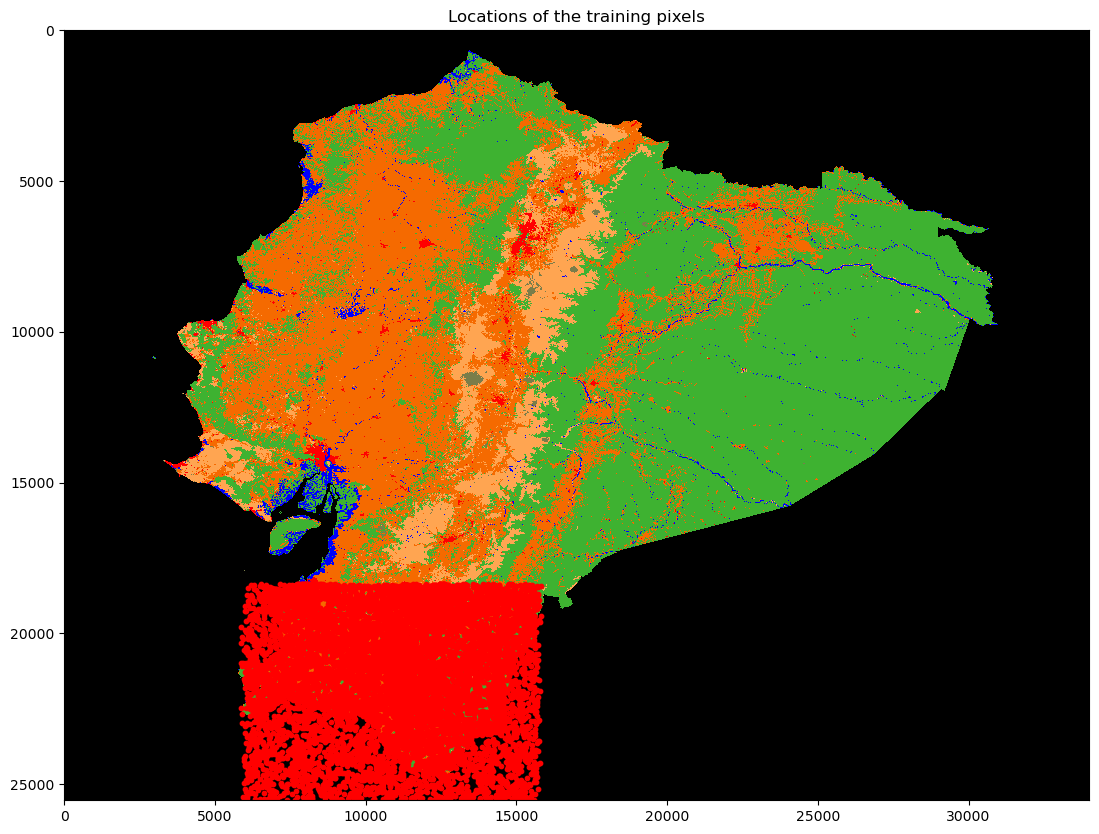

In [31]:
fig, axs = plt.subplots(figsize=(1.62*10, 10))

# location of training pixels on the image
_ = axs.imshow(labels_image[0, :, :],
               cmap=cmap_false_colors,
               interpolation='none')
axs.scatter(label_locations[:, 1], label_locations[:, 0], s=10, c='r')
axs.set_title("Locations of the training pixels")
plt.show()

## Probando el generador de datos

In [32]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, dataset_labels, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----


### Visualización de los mosaicos

Ahora vamos a visualizar los azulejos reales. Tenga en cuenta que se verán poco naturales porque han sido normalizados.

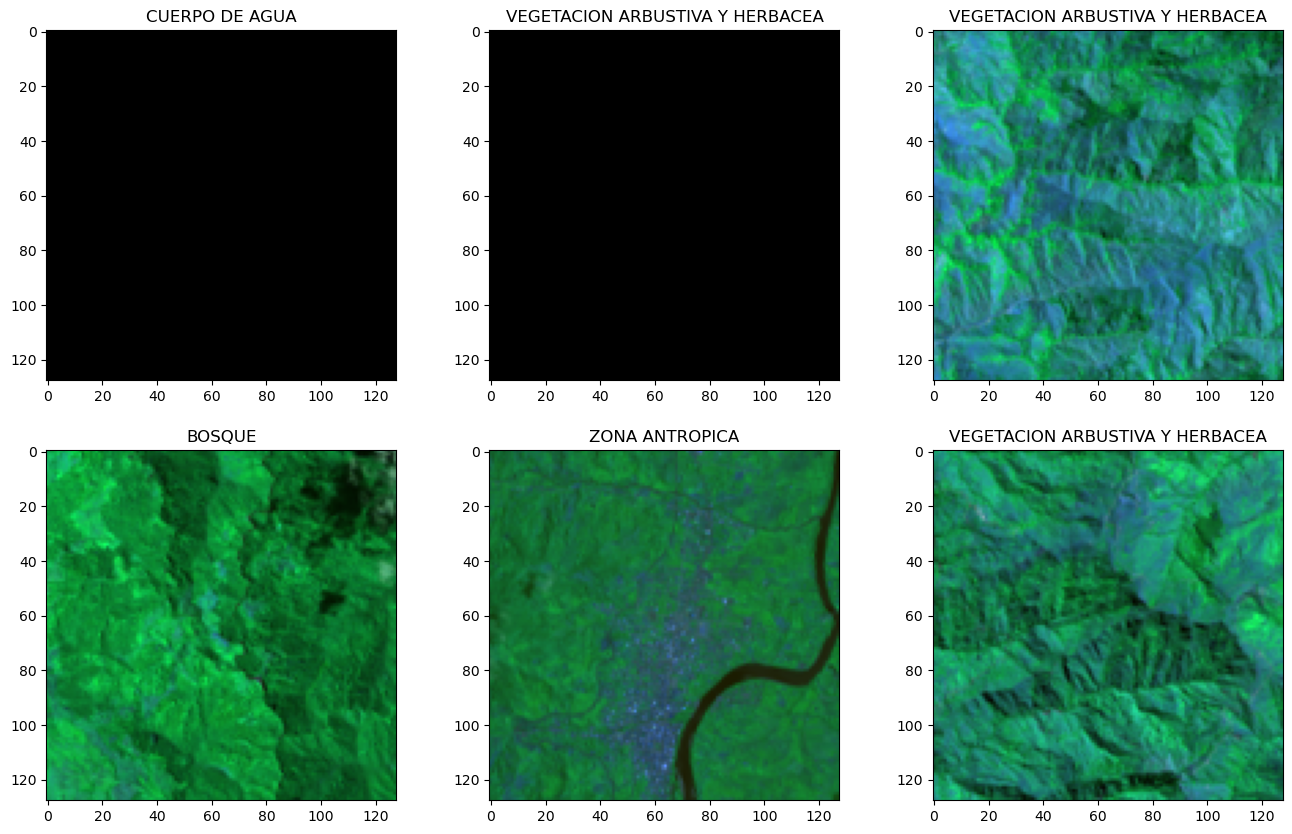

In [33]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))


fig, axes = plt.subplots(2, 3, figsize=(1.62*10, 10))
axes[0, 0].imshow(normalize(im_batch[0, :, :, 3:6]))
axes[0, 0].set_title(class_names[np.argmax(label_batch[0])])

axes[0, 1].imshow(normalize(im_batch[1, :, :, 3:6]))
axes[0, 1].set_title(class_names[np.argmax(label_batch[1])])

axes[0, 2].imshow(normalize(im_batch[2, :, :, 3:6]))
axes[0, 2].set_title(class_names[np.argmax(label_batch[2])])

axes[1, 0].imshow(normalize(im_batch[3, :, :, 3:6]))
axes[1, 0].set_title(class_names[np.argmax(label_batch[3])])

axes[1, 1].imshow(normalize(im_batch[4, :, :, 3:6]))
axes[1, 1].set_title(class_names[np.argmax(label_batch[4])])

axes[1, 2].imshow(normalize(im_batch[5, :, :, 3:6]))
axes[1, 2].set_title(class_names[np.argmax(label_batch[5])])

plt.show()

## Generar conjunto de datos de entrenamiento de 1x1 azulejos para scikit-learn para visualizar los datos

In [34]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, dataset_labels, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 7)
----


### Redimencionar 
Remodelar porque scikit-learn necesita datos en formato `(muestras, bandas)`:

In [35]:
im_batch[0, :, :, :]

array([[[-0.91267998, -0.91267998, -0.91267998, -0.91267998,
         -0.91267998, -0.91267998, -0.91267998]]])

In [36]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

array([-0.91267998, -0.91267998, -0.91267998, -0.91267998, -0.91267998,
       -0.91267998, -0.91267998])

## Visualizar Firmas Espectrales

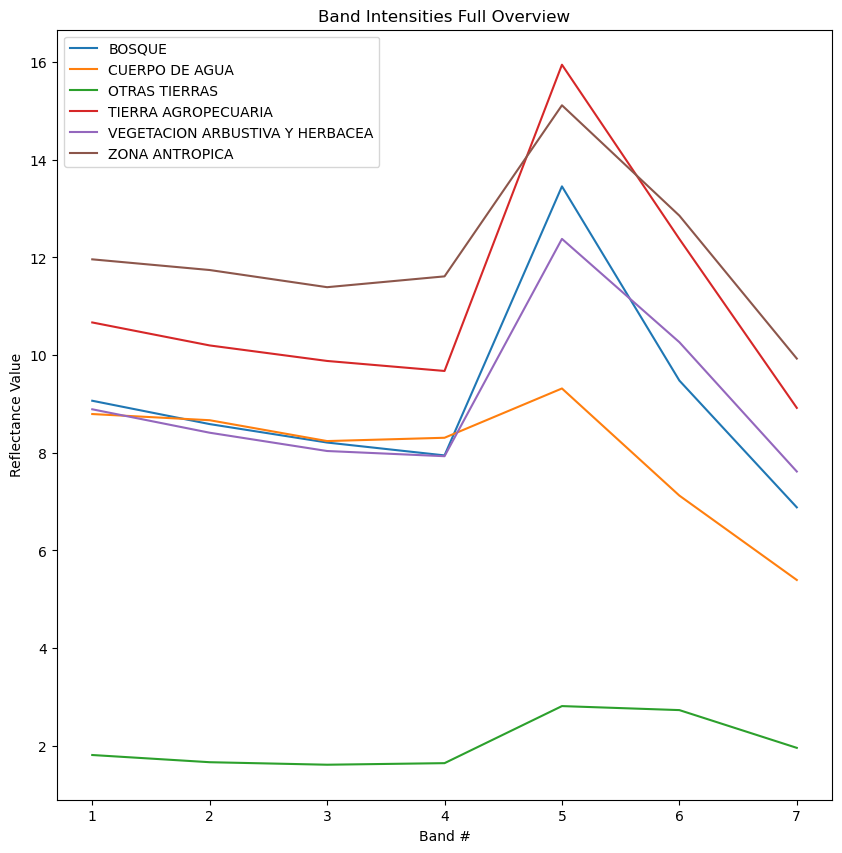

In [37]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

#

In [38]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay

## Establecer los hiperparámetros

In [39]:
batch_size = 25
epochs = 25
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


## Arquitectura CNN

In [40]:
dropout_rate = 0.1
l1 = tf.keras.regularizers.l1(0)

model = Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', activity_regularizer=l1))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(3200, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

print("\nModel architecture:\n")
model.summary()


Model architecture:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 7)        28        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4096      
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                  

## Métricas y compilar el modelo

In [41]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.0003), metrics=['accuracy'])

## Divida los datos en entrenamiento y validación

In [42]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

# Training samples: 11995 
# Validation samples: 2999


In [43]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Se ha alcanzado el umbral PRESICION. Entrenamiento detenido.....")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [44]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='logs/cnn')

history = model.fit(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size, merge=True
    ),
    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
    validation_data=tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True),
    validation_steps=len(val_px) // batch_size,
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/25
479/479 [==============================] - 5446s 11s/step - loss: 1.5797 - accuracy: 0.3617 - val_loss: 1.5020 - val_accuracy: 0.3987
Epoch 2/25
479/479 [==============================] - 5483s 11s/step - loss: 1.4108 - accuracy: 0.4383 - val_loss: 1.4141 - val_accuracy: 0.4447
Epoch 3/25
479/479 [==============================] - 5438s 11s/step - loss: 1.3354 - accuracy: 0.4727 - val_loss: 1.3474 - val_accuracy: 0.4750
Epoch 4/25
479/479 [==============================] - 5385s 11s/step - loss: 1.2687 - accuracy: 0.5000 - val_loss: 1.3224 - val_accuracy: 0.4713
Epoch 5/25
479/479 [==============================] - 5378s 11s/step - loss: 1.1699 - accuracy: 0.5367 - val_loss: 1.3415 - val_accuracy: 0.4787
Epoch 6/25
479/479 [==============================] - 5379s 11s/step - loss: 1.0709 - accuracy: 0.5760 - val_loss: 1.6356 - val_accuracy: 0.4518
Epoch 7/25
479/479 [==============================] - 5375s 11s/step - loss: 0.9502 - accuracy: 0.6257 - val_loss: 1.7882 - val_ac

## Visualización de las curvas de entrenamiento y validación

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model error")
plt.ylabel("Error")
plt.xlabel("Epoch")
_ = plt.legend(['Train', 'Test'], loc='upper left')

# Guardar el modelo entrenado

In [ ]:
save_path = './models/'
model.save(f"{save_path}model_l8_s2_v2.h5")
print("Saved model to disk")

## Compruebe la precisión de las pruebas basándose en una matriz de confusión:

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True
    ),
    steps=len(val_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    val_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

### Trazar matriz de confusión no normalizada

In [ ]:
plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

# Comprobación de la precisión del entrenamiento basándote en una matriz de confusión

¿Cómo de bien predice el modelo los datos de entrenamiento?

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size,
        merge=True
    ),
    steps=len(train_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    train_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

### Trazar matriz de confusión no normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")